In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# 1. 处理成分数据

In [ ]:
# def parse_elements(composition):
#     pattern = r"\(([A-Za-z\d.]+)\)([\d.]+)|([A-Z][a-z]*)([\d.]+)?"
#     matches = re.findall(pattern, composition)
#     elements = {}
#     for match in matches:
#         if match[0]:  # 如果有括号
#             sub_scale_factor = sum(float(x[1]) if x[1] else 1 for x in re.findall(r"([A-Z][a-z]*)([\d.]+)?", match[0]))
#             scale_factor = float(match[1]) / sub_scale_factor
#             sub_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", match[0])
#             for sub_match in sub_matches:
#                 if sub_match[0] not in elements:
#                     elements[sub_match[0]] = float(sub_match[1]) * scale_factor if sub_match[1] else scale_factor
#         elif match[2]:  # 如果没有括号
#             if match[2] not in elements:
#                 elements[match[2]] = float(match[3]) if match[3] else 1
#     sorted_elements = {key: value for key, value in sorted(elements.items(), key=lambda item: item[1], reverse=True)}
#     element_strings = [f"{element}{round(value,2)}" for element, value in sorted_elements.items()]
#     chem = "".join(element_strings)
#     return elements, chem

def parse_elements(composition):
    pattern = r"\[([A-Za-z\d.\(\)]+)]([\d.]+)|\(([A-Za-z\d.]+)\)([\d.]+)|([A-Z][a-z]*)([\d.]+)?"
    matches = re.findall(pattern, composition)
    elements = {}

    for match in matches:
        if match[0]:  # 如果有方括号
            bracket_scale_factor = float(match[1])
            bracket_content = match[0]
            bracket_matches = re.findall(pattern, bracket_content)

            for bracket_match in bracket_matches:
                if bracket_match[2]:  # 如果有括号
                    paren_scale_factor = float(bracket_match[3])
                    paren_content = bracket_match[2]
                    paren_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", paren_content)

                    for element, weight in paren_matches:
                        scaled_weight = float(weight) * paren_scale_factor * bracket_scale_factor if weight else paren_scale_factor * bracket_scale_factor

                        if element not in elements:
                            elements[element] = scaled_weight
                        else:
                            elements[element] += scaled_weight
                        
                elif bracket_match[4]:  # 如果没有括号
                    element, weight = bracket_match[4], bracket_match[5]
                    scaled_weight = float(weight) * bracket_scale_factor if weight else bracket_scale_factor

                    if element not in elements:
                        elements[element] = scaled_weight
                    else:
                        elements[element] += scaled_weight

        elif match[2]:  # 如果有括号，但没有方括号
            paren_scale_factor = float(match[3])
            paren_content = match[2]
            paren_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", paren_content)

            for element, weight in paren_matches:
                scaled_weight = float(weight) * paren_scale_factor if weight else paren_scale_factor

                if element not in elements:
                    elements[element] = scaled_weight
                else:
                    elements[element] += scaled_weight

        elif match[4]:  # 如果没有括号和方括号
            element, weight = match[4], match[5]
            scaled_weight = float(weight) if weight else 1

            if element not in elements:
                elements[element] = scaled_weight
            else:
                elements[element] += scaled_weight

    sorted_elements = {key: value for key, value in sorted(elements.items(), key=lambda item: item[1], reverse=True)}
    element_strings = [f"{element}{round(value,2)}" for element, value in sorted_elements.items()]
    chem = "".join(element_strings)
    return elements, chem


def check_sum(elements):
    total = sum(elements.values())
    return round(total, 2)

# 使用parse_elements和check_sum函数解析和检查成分
def parse_and_check(composition):
    elements, chem = parse_elements(composition)
    is_sum_100 = check_sum(elements)
    if abs(is_sum_100 - 100) > 0.5:
        print(f"Warning: {composition} is not normalized. Sum is {is_sum_100}")
    return elements, chem, abs(is_sum_100 - 100) < 0.5

In [ ]:
def parse_elements(composition):
    pattern = r"\{([^\{\}]+)\}([\d.]+)|\[([^\[\]]+)\]([\d.]+)|\(([A-Za-z\d.]+)\)([\d.]+)|([A-Z][a-z]*)([\d.]+)?"
    elements = {}

    def adjust_weight(wt):
        # 将大于1的权重调整为0-1之间，小于等于1的保持不变
        return wt/100 if wt > 1 else wt

    def parse(match, scale_factor=1.0, is_outermost=True):
        for inner_match in re.findall(pattern, match):
            if inner_match[0]:  # 大括号内容
                parse(inner_match[0], float(inner_match[1]) * scale_factor, False)
            elif inner_match[2]:  # 方括号内容
                parse(inner_match[2], float(inner_match[3]) * scale_factor, False)
            elif inner_match[4]:  # 圆括号内容
                for elem, amt in re.findall(r"([A-Z][a-z]*)([\d.]+)", inner_match[4]):
                    weight = adjust_weight(float(amt)) * float(inner_match[5]) * scale_factor
                    elements[elem] = elements.get(elem, 0) + weight
            else:  # 普通元素
                elem, amt = inner_match[6], inner_match[7]
                weight = float(amt) if amt else 1.0
                if not is_outermost:
                    weight = adjust_weight(weight)
                weight *= scale_factor
                elements[elem] = elements.get(elem, 0) + weight

    parse(composition)

    sorted_elements = {k: v for k, v in sorted(elements.items(), key=lambda item: item[1], reverse=True)}
    element_strings = [f"{el}{round(val,2)}" for el, val in sorted_elements.items()]
    chem = "".join(element_strings)
    return elements, chem


def check_sum(elements):
    total = sum(elements.values())
    return round(total, 2)

# 使用parse_elements和check_sum函数解析和检查成分
def parse_and_check(composition):
    elements, chem = parse_elements(composition)
    is_sum_100 = check_sum(elements)
    if abs(is_sum_100 - 100) > 0.5:
        print(f"Warning: {composition} is not normalized. Sum is {is_sum_100}")
    return elements, chem, abs(is_sum_100 - 100) < 0.5

In [ ]:
parse_and_check("La62Al14(Cu5Ag1)20(Ni1Co1)4")

In [ ]:
data_o = pd.read_excel("./All/ALL_data.xlsx")
record_chem = {}
for index, row in data_o.iterrows():
    composition = row["BMGs"]
    if composition in record_chem:
        pass
        # print(record_chem[composition], index, composition)
    else:
        record_chem[composition] = index
    elements, chem, is_sum_100 = parse_and_check(composition)

    if not is_sum_100:
        print(f"index {index} sum {is_sum_100}:\n{row}\n")
    data_o.loc[index, "Chemical compostion"] = chem
    # 将新的成分列添加到DataFrame中
    for element, value in elements.items():
        if element not in data_o.columns:
            data_o[element] = 0
        data_o.loc[index, element] = value

In [ ]:
# data_o.replace("–", "", inplace=True)
data_o.drop_duplicates(subset='Chemical compostion', keep='first', inplace=True)
data_o.describe().to_excel("./All/All_data_des.xlsx")
data_o.to_excel("./All/All_data_processed.xlsx", index=False)

# 2. 绘制数据分析图

In [3]:
configs = {
    'NewCriterion': {
        "save_path": "./NewCriterion",
        "data_path": "./NewCriterion/NewCriterion_processed.xlsx",
        "drop_columns": ["BMGs", "Chemical compostion"],
        "target_names": ["Tg(K)", "Tx(K)", "Tl(K)", "Dmax(mm)"]
    },
    "NCSupply": {
        "save_path": "./NCSupply",
        "data_path": "./NCSupply/NCSupply_processed.xlsx",
        "drop_columns": ["BMGs", "Chemical compostion"],
        "target_names": ["Tg(K)", "Tl(K)", "Dmax(mm)"]
    },
    'CTT Dataset': {
        "save_path": "./Xiong's Data",
        "data_path": "./Xiong's Data/CTT Dataset_processed.xlsx",
        "drop_columns": ["BMGs", "Chemical compostion"],
        "target_names": ["Tg(K)", "Tx(K)", "Tl(K)", "Dmax(mm)"]
    },
    'Wang': {
        "save_path": "./Wang's Data",
        "data_path": "./Wang's Data/Wang_processed.xlsx",
        "drop_columns": ["BMGs", "Chemical compostion"],
        "target_names": ["E(GPa)", "Tg(K)", "Tm(K)", "ry(GPa)", "Tx(K)", "Tl(K)", "Dmax(mm)"]
    },
    'Bian': {
        "save_path": "./Bian's Data",
        "data_path": "./Bian's Data/Bian_processed.xlsx",
        "drop_columns": ["BMGs", "Chemical compostion"],
        "target_names": ["Dmax(mm)", "Tg(K)", "Tx(K)", "Tl(K)", "σy(MPa)", "Modulus (GPa)", "Ε(%)"]
    },
    'ALL': {
        "save_path": "./All",
        "data_path": "./All/All_data_processed.xlsx",
        "drop_columns": ["BMGs", "Chemical compostion"],
        "target_names": ["Tg(K)", "Tx(K)", "Tl(K)", "Dmax(mm)", "yield(MPa)", "Modulus (GPa)", "Ε(%)"]
    }

}

In [4]:
# 设置箱线图样式
boxprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='--', linewidth=1.5, color='gray')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red', alpha=0.7)
medianprops = dict(linestyle='-', linewidth=2, color='blue')

def draw_box(data, target_name, save_path):
    plt.cla()
    data_d = [data]

    # 设置每组数据对应的标签
    labels = [target_name]

    # 绘制箱线图
    plt.boxplot(data_d, vert=False, showmeans=True, meanline=True,
                boxprops=boxprops, whiskerprops=whiskerprops, flierprops=flierprops, medianprops=medianprops, labels=labels)

    # 添加标题和标签
    plt.title(f'{target_name} Target Distributions(Filter)')
    plt.xlabel('Range')

    # 显示图形
    plt.savefig(f"{save_path}/{target_name}_box.png", dpi=300)
    plt.close()

def element_hist(data_f, save_path):
    # 计算每个元素的出现频率
    element_count = (data_f != 0).sum()

    # 按频率降序排序
    element_count_sorted = element_count.sort_values(ascending=False)

    # 创建图形
    fig, ax = plt.subplots(figsize=(20, 12))

    # 绘制条形图，元素按频率降序显示
    ax.bar(element_count_sorted.index, element_count_sorted.values)
    ax.set_xlabel("Elements")
    ax.set_ylabel("Frequency")
    ax.set_title("Element Frequency in Compositions")

    # 保存图像
    plt.savefig(f"{save_path}/element_statistics.png", dpi=300)
    plt.close()
    
def draw_target_hist(data_f, target_name, save_path):
    plt.cla()
    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制直方图
    ax.hist(data_f, bins=20, edgecolor='black')

    # 添加标题和标签
    ax.set_title(f'{target_name} Distribution')
    ax.set_xlabel(target_name)
    ax.set_ylabel('Frequency')

    # 保存图像
    plt.savefig(f"{save_path}/{target_name}_hist.png", dpi=300)
    plt.close()

def plot_element_proportions(data_f, save_path):
    # 计算每种元素的总和
    element_totals = data_f.sum()

    # 计算总和，用于确定每种元素的占比
    total_sum = element_totals.sum()

    # 计算每种元素占总元素的比例，并转换为百分比
    proportions = (element_totals / total_sum) * 100

    # 将比例小于3%的元素归类为“Others”
    small_proportions = proportions[proportions < 3]
    proportions = proportions[proportions >= 3]
    proportions['Others'] = small_proportions.sum()

    # 排序，以便在饼图上有序显示
    proportions = proportions.sort_values(ascending=False)

    # 选择一个配色方案
    colors = plt.get_cmap('tab20').colors

    # 绘制饼图
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.pie(proportions, labels=proportions.index, startangle=140, 
                                       colors=colors, explode=[0.01]*len(proportions), autopct='%1.1f%%')
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)

    # 等比例显示，保证饼图为圆形
    ax.axis('equal')

    # 设置标题
    plt.title("Element Proportions", weight='bold', size='x-large')

    # 保存图像
    plt.savefig(f"{save_path}/element_proportions.png", dpi=300, bbox_inches='tight')

    plt.close()

def plot_element_count(data_f, save_path):
    max_elements = data_f.idxmax(axis=1)
    # 计算每种元素作为最大元素出现的次数
    element_counts = max_elements.value_counts()
    element_counts = (element_counts / len(max_elements)) * 100
     # 将比例小于3%的元素归类为“Others”
    small_proportions = element_counts[element_counts < 3]
    element_counts = element_counts[element_counts >= 3]
    element_counts['Others'] = small_proportions.sum()

    pie_data = element_counts
    pie_data = pie_data.sort_values(ascending=False)
    colors = plt.get_cmap('tab20').colors  # 选择颜色方案
    
    # 绘制饼图
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.pie(pie_data, labels=pie_data.index, startangle=140, 
                                       colors=colors, explode=[0.01]*len(pie_data), autopct='%1.1f%%')
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)

    ax.axis('equal')  # 等比例显示

    plt.title("Element Max Proportion Counts")
    plt.savefig(f"{save_path}/element_max_proportion_counts.png", dpi=300, bbox_inches='tight')
    plt.close()


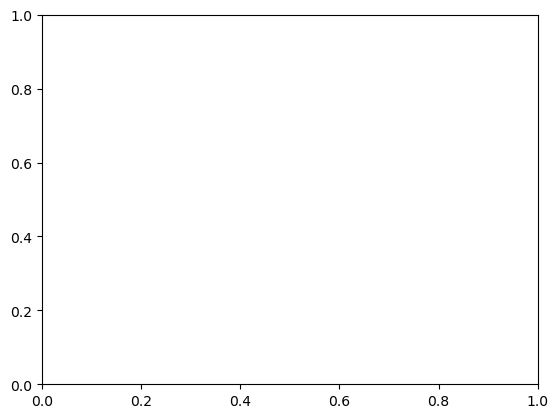

In [5]:
for dataset in configs.keys():
    data = pd.read_excel(configs[dataset]["data_path"])
    save_path = configs[dataset]["save_path"]
    target_names = configs[dataset]["target_names"]
    drop_columns = configs[dataset]["drop_columns"]
    # 从特征中删除目标名称和不需要的列
    data_f = data.drop(target_names, axis=1, inplace=False)
    data_f = data_f.drop(drop_columns, axis=1, inplace=False)
    # 绘制箱图
    for target in target_names:
        non_empty_values = data.dropna(subset=[target])[target]
        draw_box(non_empty_values, target.replace('/', '_'), save_path)
    # 绘制柱状图
    for target in target_names:
        draw_target_hist(data, target, save_path)


    # 绘制元素直方图
    element_hist(data_f, save_path)
    # 绘制元素占比饼图
    plot_element_proportions(data_f, save_path)
    # 绘制元素最大占比饼图
    plot_element_count(data_f, save_path)
        